In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from PIL import Image

import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torchsummary
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

#from tqdm import tqdm
from tqdm.notebook import tqdm

from torchviz import make_dot

from torchmetrics.classification import BinaryRecall, BinaryPrecision, BinaryF1Score

In [19]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


In [4]:
base_path = "C:\\Users\\johnn\\Desktop\\Repos\\Capstonfire"
dataset_path = base_path + "\\full dataset"
#dataset_path = base_path + "\\FIRE + Forest Fire datasets"
test_path = base_path + "\\test dataset"
pretrained_models_path = base_path + "\\trained_models\\"

In [5]:
fire_files = os.listdir(dataset_path + "\\fire_images")
non_fire_files = os.listdir(dataset_path + "\\non_fire_images")

In [6]:
# Cenário de avaliação 1

# ir buscar ~1000 imagens com fogo
fire_files_val = ...

# ir buscar ~1000 imagens sem fogo
non_fire_files_val = ...

# Cenário de avaliação 2

# buscar ~200 imagens de validação de fogo e manter as 1000 de fogo


# ou ir buscar vídeos de fogos - preferencial

In [7]:
class FireDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        # Store the folder names in a dictionary as the class names alongside the class numeric label
        self.class_to_idx = {} 
        for i, cls in enumerate(self.classes):
            self.class_to_idx[cls] = i

        self.data = self._load_data()

    def _load_data(self):
        data = []
        for class_name in self.classes: # Fetch the folders through the class name
            class_path = os.path.join(self.root_dir, class_name)
            for filename in os.listdir(class_path): # Fetch the images inside each folders
                img_path = os.path.join(class_path, filename) # Obtain the name of the current image
                data.append((img_path, self.class_to_idx[class_name])) # Add the image to a list paired with its class' numeric label
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label

Label: 0
Image shape: torch.Size([3, 256, 256])


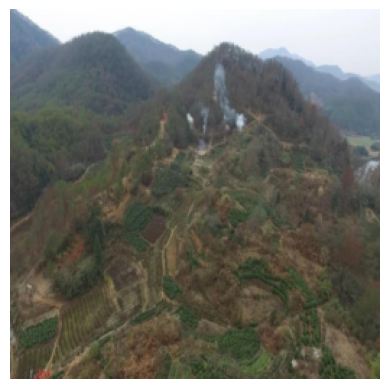

In [21]:
transform = transforms.Compose([
    transforms.Resize((256, 256)), # create a new model that resizes images based on aspect ratio
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.to(device))
])

dataset = FireDataset(dataset_path, transform=transform)

# Access an image and its label
img, label = dataset[0]
print("Label:", label)
# The image is a PyTorch tensor
print("Image shape:", img.shape)

# Convert the PyTorch tensor to a NumPy array and permute dimensions if necessary
img_np = img.detach().cpu().numpy() if img.is_cuda else img.numpy()

img_np = np.transpose(img_np, (1, 2, 0))

# Display the image using Matplotlib
plt.imshow(img_np)
plt.axis('off')
plt.show()

In [22]:
batch_size = 50

In [23]:
train_size = 0.7
val_size = 0.2
test_size = 0.1

train_dataset, val_dataset, test_dataset = random_split(dataset=dataset, lengths=[train_size, val_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [24]:
len(train_loader.dataset)

4847

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3) # to capture basic patterns from the image
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3) # to capture basic patterns from the previous patterns (results in capturing more complex patterns from the original image)
        self.conv3 = nn.Conv2d(32, 16, kernel_size=3)
        self.fc1 = nn.Linear(16*30*30, 256) # number of channels of the last Conv2D (10) * width obtained from the kernels (30) * height (30)
        self.fc2 = nn.Linear(256, 1) # DNN > WNN; also 1 classes
        # self.fc2 = nn.Linear (256, 64)
        # self.fc3 = nn.Linear (64, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(-1, 16*30*30)
        x = F.relu(self.fc1(x))
        #x = torch.sigmoid(self.fc2(x)) #used in binary classification
        x = self.fc2(x)
        #return F.log_softmax(x, dim=1) #used in multi-class classification 
        return x

model = SimpleCNN().to(device)

In [26]:
torchsummary.summary(model=model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 254, 254]             448
            Conv2d-2         [-1, 32, 125, 125]           4,640
            Conv2d-3           [-1, 16, 60, 60]           4,624
            Linear-4                  [-1, 256]       3,686,656
            Linear-5                    [-1, 1]             257
Total params: 3,696,625
Trainable params: 3,696,625
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 12.13
Params size (MB): 14.10
Estimated Total Size (MB): 26.98
----------------------------------------------------------------


In [35]:
x = torch.randn(50, 3, 256, 256).to(device)  # A dummy input tensor to pass through the model
y = model(x)

dot = make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))
dot.render('model details/model_visualization', format='png')

'model details\\model_visualization.png'

In [36]:
# Step 2: Define Loss Function and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

In [14]:
model_name = "capstonfire_cnn_all_datasets"
#model_name = "capstonfire_cnn"

In [38]:
history = {
    "avg_train_loss_list": [],
    "train_accuracy_list": [],
    "avg_val_loss_list": [],
    "val_accuracy_list": []
}

In [27]:
 # Step 3: Training Loop
 # avoid loop if the model was already trained

if model_name + '.pt' in os.listdir(pretrained_models_path):
    model.load_state_dict(torch.load(pretrained_models_path + model_name +'.pt'))

# if model was never trained, enter loop
else:
    num_epochs = 20
    for epoch in tqdm(list(range(num_epochs))):
        model.train()

        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # For binary classification, modify target labels shape
            labels = labels.view(-1, 1).float()

            optimizer.zero_grad()  # zero the parameter gradients
            outputs = model(inputs)  # forward
            loss = criterion(outputs, labels)  # calculate loss
            loss.backward()  # backward
            optimizer.step()  # optimize

            predicted_binary = (torch.sigmoid(outputs) > 0.5).float()
            correct_train += (predicted_binary == labels).sum().item()
            
            total_train += labels.size(0)

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
            
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            correct_val = 0
            total_val = 0
            val_loss = 0.0

            for inputs_val, labels_val in val_loader:
                inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)

                labels_val = labels_val.view(-1, 1).float()

                outputs_val = model(inputs_val)
                loss_val = criterion(outputs_val, labels_val)

                predicted_binary = (torch.sigmoid(outputs_val) > 0.5).float()
                correct_val += (predicted_binary == labels_val).sum().item()

                total_val += labels_val.size(0)

                val_loss += loss_val.item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct_val / total_val

        history["avg_train_loss_list"].append(avg_train_loss)
        history["train_accuracy_list"].append(train_accuracy)
        history["avg_val_loss_list"].append(avg_val_loss)
        history["val_accuracy_list"].append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
            f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
            f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    print('Finished Training')

In [40]:
# save pytorch model
torch.save(model.state_dict(), "trained_models/" + model_name + '.pt')

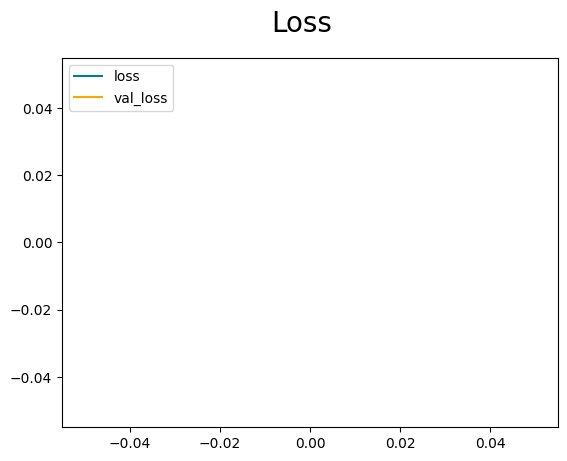

In [41]:
fig = plt.figure()
plt.plot(history["avg_train_loss_list"], color='teal', label='loss')
plt.plot(history["avg_val_loss_list"], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

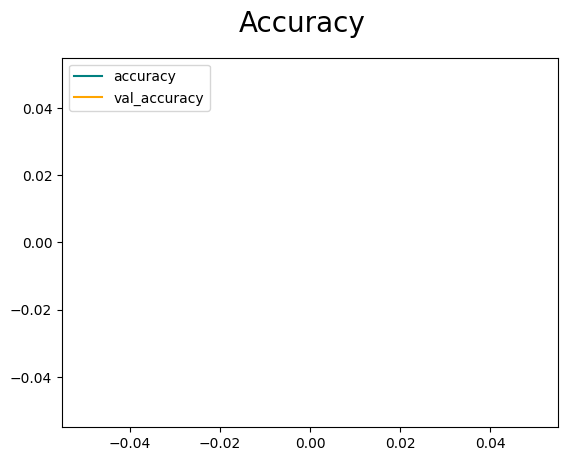

In [ ]:
fig = plt.figure()
plt.plot(history["train_accuracy_list"], color='teal', label='accuracy')
plt.plot(history["val_accuracy_list"], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
# Step 4: Evaluation

# What's the loss on the train set?
total_loss = []
with torch.no_grad():
    for data in tqdm(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        labels = labels.view(-1, 1).float()

        optimizer.zero_grad()  # zero the parameter gradients
        outputs = model(inputs)  # forward

        loss = criterion(outputs, labels)  # calculate loss
        total_loss.append(loss.item())
print('Loss on the train set: %.3f' % (sum(total_loss) / len(total_loss)))


# What's the loss on the test set?
total_loss = []
with torch.no_grad():
    for data in tqdm(val_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        labels = labels.view(-1, 1).float()

        optimizer.zero_grad()  # zero the parameter gradients
        outputs = model(inputs)  # forward
        
        loss = criterion(outputs, labels)  # calculate loss
        total_loss.append(loss.item())
print('Loss on the val set: %.3f' % (sum(total_loss) / len(total_loss)))

  0%|          | 0/97 [00:00<?, ?it/s]

Loss on the train set: 0.151


  0%|          | 0/28 [00:00<?, ?it/s]

Loss on the val set: 0.154


In [42]:
recall = BinaryRecall(threshold=0.5).to(device)
precision = BinaryPrecision(threshold=0.5).to(device)
f1 = BinaryF1Score(threshold=0.5).to(device)

with torch.no_grad():
    for data in tqdm(test_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1, 1).float()
        outputs = model(inputs)  # forward
        predicted_binary = (torch.sigmoid(outputs) > 0.5).float()
        #predictions = torch.argmax(outputs, dim=1)

        recall.update(predicted_binary, labels)
        precision.update(predicted_binary, labels)
        f1.update(predicted_binary, labels)

print('Recall on the test set: %.2f' % (recall.compute()))
print('Precision on the test set: %.2f' % (precision.compute()))
print('F1 Score on the test set: %.2f' % (f1.compute()))

  0%|          | 0/14 [00:00<?, ?it/s]

Recall on the test set: 0.90
Precision on the test set: 0.95
F1 Score on the test set: 0.93


In [ ]:
custom_test_loader = DataLoader(FireDataset(test_path, transform=transform), batch_size=batch_size, shuffle=False)

with torch.no_grad():
    for data in tqdm(custom_test_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1, 1).float()
        outputs = model(inputs)  # forward
        predicted_binary = (torch.sigmoid(outputs) > 0.5).float()
        #predictions = torch.argmax(outputs, dim=1)

        recall.update(predicted_binary, labels)
        precision.update(predicted_binary, labels)
        f1.update(predicted_binary, labels)

print('Recall on the test set: %.2f' % (recall.compute()))
print('Precision on the test set: %.2f' % (precision.compute()))
print('F1 Score on the test set: %.2f' % (f1.compute()))

  0%|          | 0/19 [00:00<?, ?it/s]

Recall on the test set: 0.43
Precision on the test set: 0.96
F1 Score on the test set: 0.59


  0%|          | 0/19 [00:00<?, ?it/s]

0.0009298065560869873 real label:  0.0


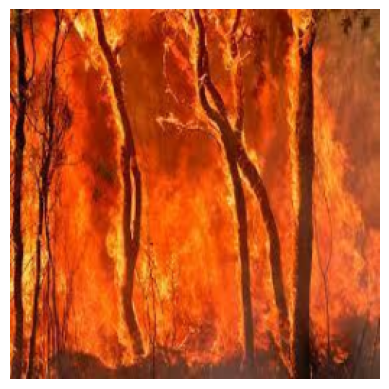

"\n        recall.update(predicted_binary, labels)\n        precision.update(predicted_binary, labels)\n        f1.update(predicted_binary, labels)\n        \n\nprint('Recall on the test set: %.2f' % (recall.compute()))\nprint('Precision on the test set: %.2f' % (precision.compute()))\nprint('F1 Score on the test set: %.2f' % (f1.compute()))"

In [ ]:
custom_test_loader = DataLoader(FireDataset(test_path, transform=transform), batch_size=batch_size, shuffle=False)

with torch.no_grad():
    i = 1
    for data in tqdm(custom_test_loader):
        inputs, labels = data
        sample_image = inputs[i]
        sample_label = labels[i]
        sample_image, sample_label = sample_image.to(device), sample_label.to(device)
        sample_label = sample_label.view(-1, 1).float()
        outputs = model(sample_image)  # forward
        predicted_binary = torch.sigmoid(outputs) #(torch.sigmoid(outputs) > 0.5).float()
        #predictions = torch.argmax(outputs, dim=1)
        print(predicted_binary.item(), "real label: ", sample_label.item())

        sample_img_np = sample_image.detach().cpu().numpy() if sample_image.is_cuda else sample_image.numpy()

        sample_img_np = np.transpose(sample_img_np, (1, 2, 0))

        # Display the image using Matplotlib
        plt.imshow(sample_img_np)
        plt.axis('off')
        plt.show()
        break
"""
        recall.update(predicted_binary, labels)
        precision.update(predicted_binary, labels)
        f1.update(predicted_binary, labels)
        

print('Recall on the test set: %.2f' % (recall.compute()))
print('Precision on the test set: %.2f' % (precision.compute()))
print('F1 Score on the test set: %.2f' % (f1.compute()))"""

In [ ]:
#cross-validation
#perturbações

In [16]:
import os
import cv2
from torchvision import datasets
import torchvision
import torch
import imutils
from torchvision.transforms import transforms
import torchvision.models as models
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imutils.video import VideoStream
Image.LOAD_TRUNCATED_IMAGES = True
plt.ion()

In [31]:
cap = cv2.VideoCapture(base_path + "\\test dataset videos\\timelapse_2.mp4")
model = model.to("cpu")
transform_video = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: x.to(device))
])
while True:
    ret, image = cap.read()

    # Check if the frame was successfully read
    if not ret:
        break

    draw = image.copy()
    draw = cv2.resize(draw, (640, 480))
    draw = transform_video(draw)

    # Add your prediction and drawing code here if needed
    #prediction, prob = predict(draw) #aqui
    outputs = model(draw)
    prob = torch.sigmoid(outputs)
    prediction = (torch.sigmoid(outputs) > 0.5).int()
    
    if prediction == 0:
        color = (0, 255, 0)
    else:
        color = (0, 0, 255)
    
    cv2.putText(image, (str(prediction.item())+' '+str(prob.item())), (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2) #aqui

    # Display the frame
    cv2.imshow('framename', image)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()